In [ ]:
#installing kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#make directory
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#json file
! cp kaggle.json ~/.kaggle/

In [ ]:
#chmod
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download dataset
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:14<00:00, 216MB/s]
100% 2.29G/2.29G [00:14<00:00, 167MB/s]


In [ ]:
#unzip images
! unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [ ]:
# import libraries
import numpy as np
import pandas as pd 
import random as rn

# import tensorflow libraries
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# import all data visualization and chart creation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob

# importing the image scanning libraries
from skimage import color, exposure
from sklearn.metrics import classification_report

# importing libraries needed to manipulate file directory libraries for saving checkpoints
import os
import cv2

# seed for repetition

seed = 80

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# matplotlib to display graphs in jupyter notebook
%matplotlib inline

print("All libraries successfully imported!")

All libraries successfully imported!


In [ ]:
# the path needed where source data is located once taken from the kaggle
data_path = '/content/chest_xray/'

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

# Compressing the image size to conserve processsing cost and expediate model prediction.
img_size = 100

In [ ]:
#Function for reading data from folders.
#Returns numpy array [img, label]
labels = ['PNEUMONIA', 'NORMAL']

def read_data(data_paths):
    for data_path in data_paths:
        images = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [ ]:
# Seperating training and test data. Test and validation were merge together as the validation folder only contained 16 images
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# Shuffling the dataset 10 times.
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [ ]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [ ]:
train_df['label'].head()

0       NORMAL
1       NORMAL
2    PNEUMONIA
3       NORMAL
4       NORMAL
Name: label, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


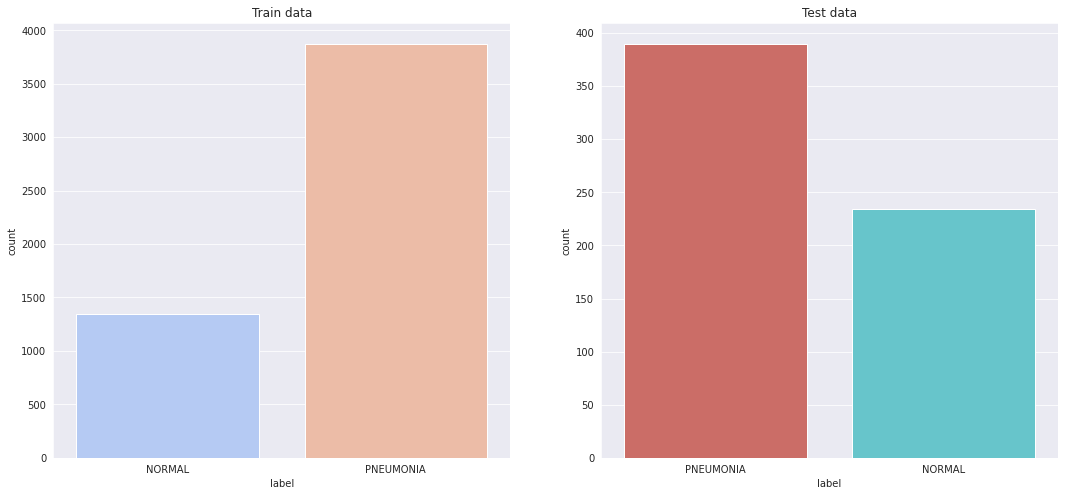

In [ ]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

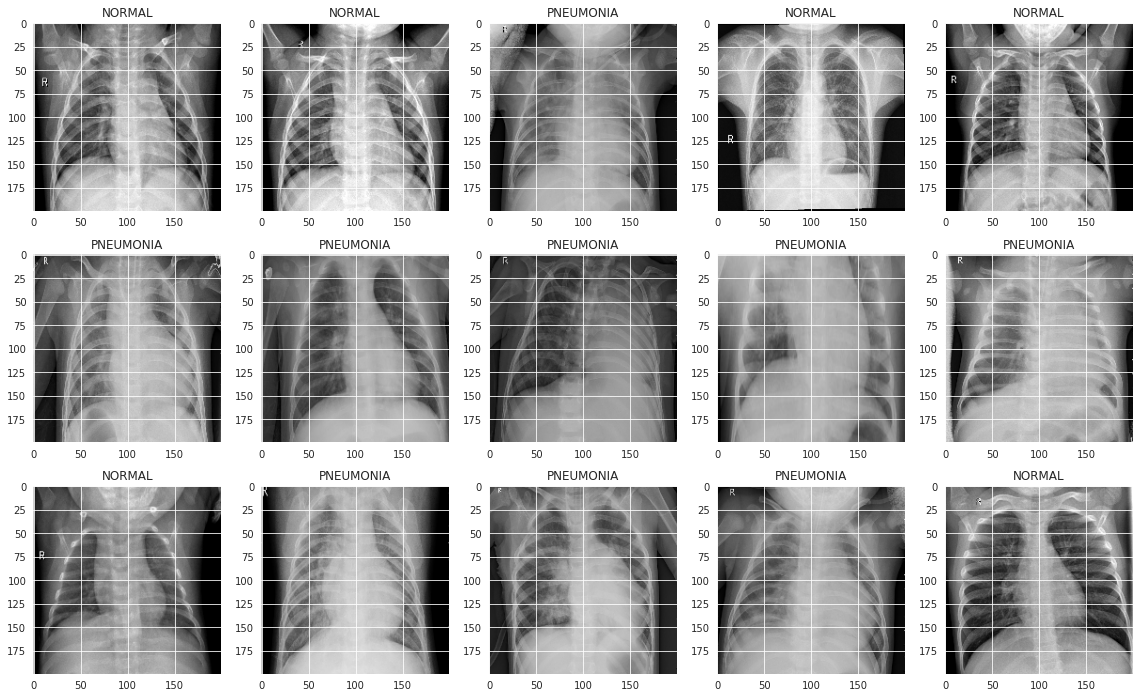

In [ ]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

# Data preprocessing

In [ ]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

#Function for dividing data into arrays X and y
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

# Split data
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

#  Grayscale conversion, normalization and table reshaping function for MLP
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

#Function to drawing learning curve history learning neural network
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()


In [ ]:
X_train = preprocesing(X_train)
X_test = preprocesing(X_test)

In [ ]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('/content/working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

#### First model

In [ ]:
def model1():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [ ]:
model = model1()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              40961024  
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the model
learning_history = model.fit(X_train, y_train,
          batch_size = 80, epochs = 50, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
82/82 - 7s - loss: 0.3943 - accuracy: 0.8232 - val_loss: 0.5443 - val_accuracy: 0.7260 - lr: 0.0010 - 7s/epoch - 91ms/step
Epoch 2/40
82/82 - 3s - loss: 0.1998 - accuracy: 0.9237 - val_loss: 0.3236 - val_accuracy: 0.8558 - lr: 0.0010 - 3s/epoch - 40ms/step
Epoch 3/40
82/82 - 3s - loss: 0.1514 - accuracy: 0.9434 - val_loss: 0.5604 - val_accuracy: 0.7676 - lr: 0.0010 - 3s/epoch - 42ms/step
Epoch 4/40
82/82 - 3s - loss: 0.1503 - accuracy: 0.9419 - val_loss: 0.7645 - val_accuracy: 0.7308 - lr: 0.0010 - 3s/epoch - 40ms/step
Epoch 5/40
82/82 - 3s - loss: 0.1217 - accuracy: 0.9551 - val_loss: 0.4721 - val_accuracy: 0.8013 - lr: 0.0010 - 3s/epoch - 41ms/step
Epoch 6/40
82/82 - 3s - loss: 0.1256 - accuracy: 0.9494 - val_loss: 0.7490 - val_accuracy: 0.7500 - lr: 0.0010 - 3s/epoch - 35ms/step
Epoch 7/40
82/82 - 4s - loss: 0.1207 - accuracy: 0.9538 - val_loss: 0.7659 - val_accuracy: 0.7516 - lr: 0.0010 - 4s/epoch - 53ms/step
Epoch 8/40
82/82 - 4s - loss: 0.1095 - accuracy: 0.9594 - val_

In [ ]:
# Loading the best model in terms of the loss metric
model = load_model('/content/working/model.best1.hdf5')

#Evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 87.87272572517395%
Test accuracy: 75.0%
MLP Error: 25.00%


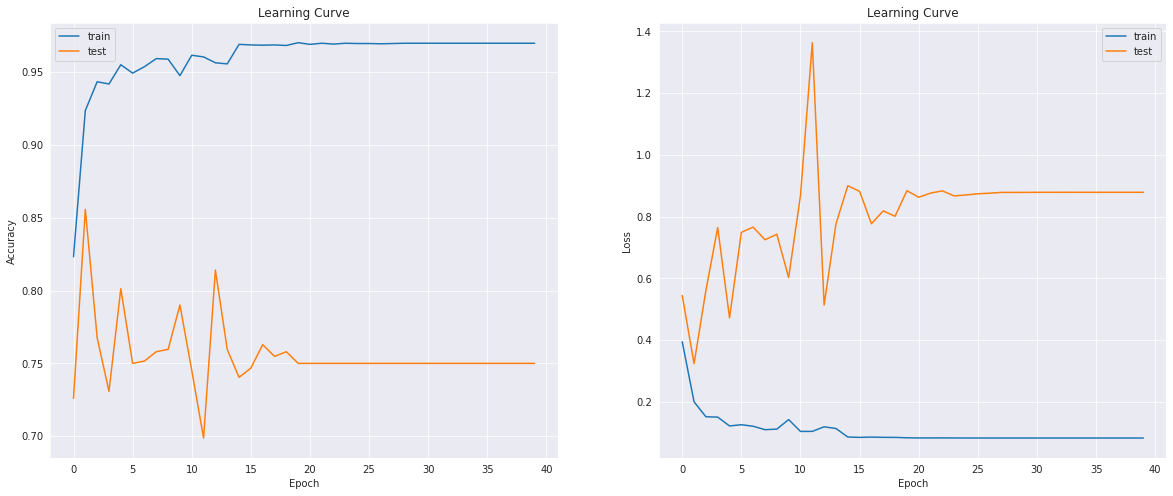

In [ ]:
draw_learning_curve(learning_history)

# Data preparing for CNN

In [ ]:
#We need to rehaspe data again
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [ ]:
#Grayscale conversion, normalization and table reshaping function for CNN
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 200
    return data1

In [ ]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
num_classes = y_train.shape[1]

In [ ]:
input_shape = (img_size, img_size, 1)

In [ ]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 10), 
    ReduceLROnPlateau(monitor = 'loss', patience = 5), 
    ModelCheckpoint('/content/model.best2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [ ]:
num_pixels 

40000

#### First model CNN

In [ ]:
def medhack22():
    return Sequential([
        
        Conv2D(20, kernel_size=(5, 5), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(20, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(45, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(45, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(84, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(84, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(200, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(200, kernel_size=(5, 5), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [ ]:
model = medhack22()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

KeyboardInterrupt: ignored

#### Fitting the model

In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks2,
          validation_data = (X_test, y_test))

Epoch 1/100
82/82 [==============================] - 28s 188ms/step - loss: 1.2214 - accuracy: 0.6988 - val_loss: 1.2767 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 12s 151ms/step - loss: 0.3643 - accuracy: 0.8585 - val_loss: 2.3314 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 13s 159ms/step - loss: 0.2392 - accuracy: 0.9112 - val_loss: 4.3300 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 13s 156ms/step - loss: 0.1784 - accuracy: 0.9317 - val_loss: 5.9872 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 13s 157ms/step - loss: 0.1603 - accuracy: 0.9492 - val_loss: 5.5680 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 13s 158ms/step - loss: 0.1537 - accuracy: 0.9542 - val_loss: 5.2318 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 13s 1

In [ ]:
model = load_model('/content/model.best2.hdf5')

In [ ]:
# Evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 278.1947612762451%
Test accuracy: 74.03846383094788%
MLP Error: 25.96%


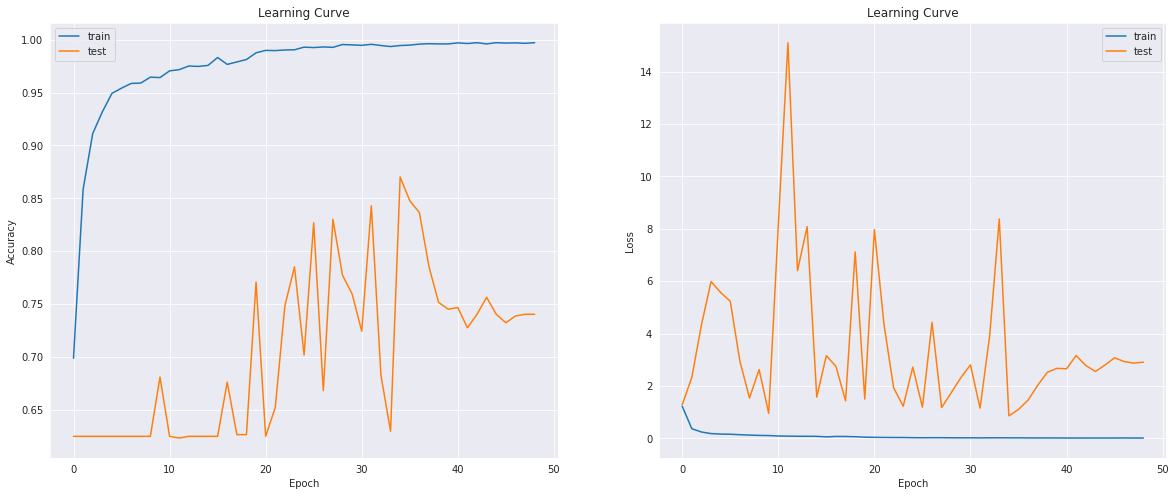

In [ ]:
draw_learning_curve(learning_history)

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg

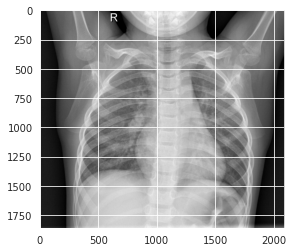

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from matplotlib.pyplot import figure

img = load_img('/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(img)

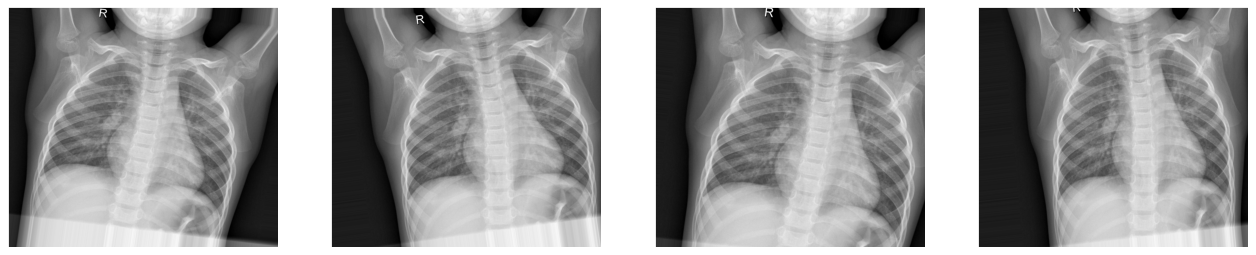

In [ ]:
data = img_to_array(img)
samples = expand_dims(data, 0)

#setting an array from which the algorith will randomly choose
datagen = ImageDataGenerator(featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

_ = datagen.flow(samples, batch_size=1)

figure(figsize=(20, 12), dpi=80)

for i in range(4):
    batch = _.next()
    image = batch[0].astype('uint8')
    plt.subplot(140 + 1 + i)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('/content/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

#### Second model CNN

In [ ]:
def medhack22_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])

#### Fitting the model

In [ ]:
learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks3,
                        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
163/163 [==============================] - 22s 121ms/step - loss: 0.5425 - accuracy: 0.7621 - val_loss: 7.1029 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 19s 119ms/step - loss: 0.2910 - accuracy: 0.8915 - val_loss: 5.6349 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 20s 120ms/step - loss: 0.2052 - accuracy: 0.9224 - val_loss: 4.2719 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 19s 119ms/step - loss: 0.1809 - accuracy: 0.9319 - val_loss: 2.0200 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 19s 119ms/step - loss: 0.1707 - accuracy: 0.9342 - val_loss: 1.4549 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 19s 119ms/step - loss: 0.1494 - accuracy: 0.9423 - val_loss: 0.3930 - val_accuracy: 0.8478 - lr: 0.0010
Epoch 7/100
163/163 [=========================

In [ ]:
model = load_model('/content/model.best3.hdf5')

In [ ]:
# Evaluate
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 26.643002033233643%
Test accuracy: 93.75%
MLP Error: 6.25%


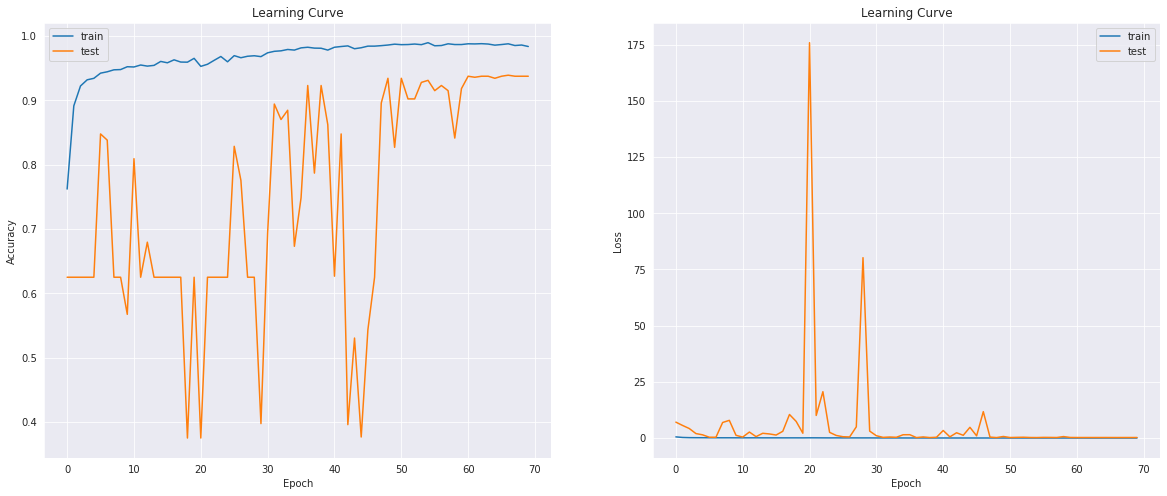

In [ ]:
draw_learning_curve(learning_history)

In [ ]:
# Let's see where the model was invalid
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
y_pre_test = np.argmax(y_test, axis = 1)

In [ ]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


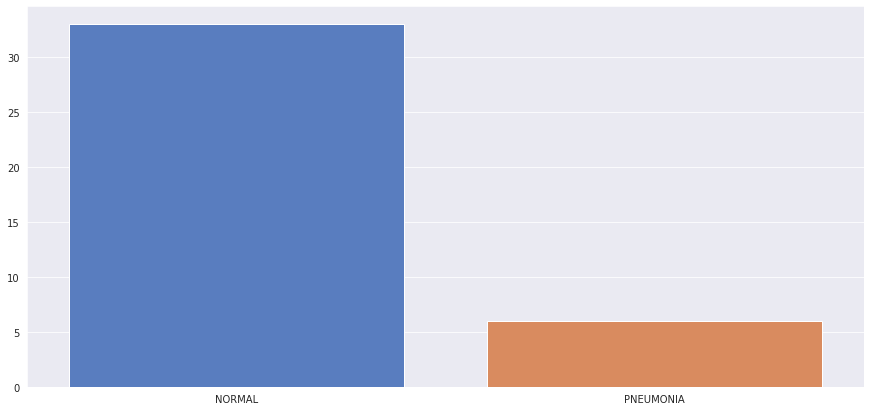

In [ ]:
# Let's see the graph with the error amount for each label.
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

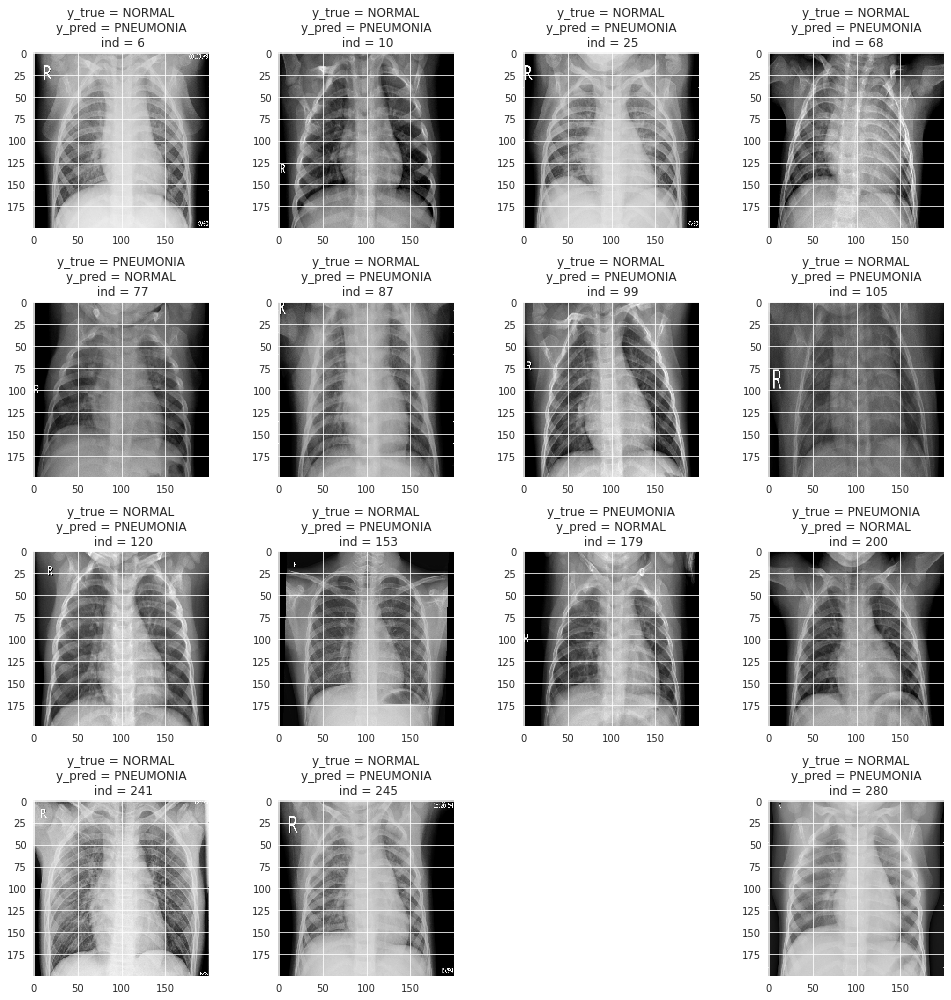

In [ ]:
# Let's show images
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

### Results

In [ ]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       234
           1       0.92      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  
    # plotting a Confusion Matrix using heatmap visualization.

    # creating the text in each square
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # generating summary texts
    if sum_stats:
        #Accuracy = diagonal sum / total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # showing more statistics if it is a binary confusion matrix
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

#setting parameters
    if figsize==None:
        #default if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #show no categories if x & y are is False
        categories=False


    # crating the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pre_test, y_pred)
#cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

Text(0.5, 69.0, 'Predicted')

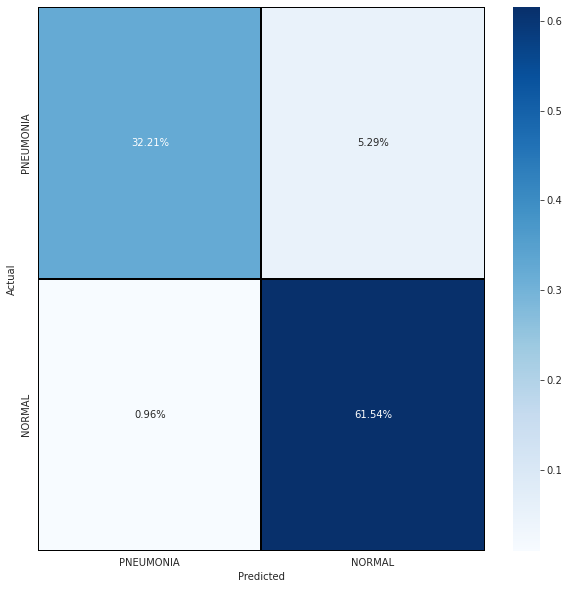

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm/np.sum(cm),
            cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True, 
            fmt='.2%',
            xticklabels = labels,
            yticklabels = labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

<Figure size 720x720 with 0 Axes>

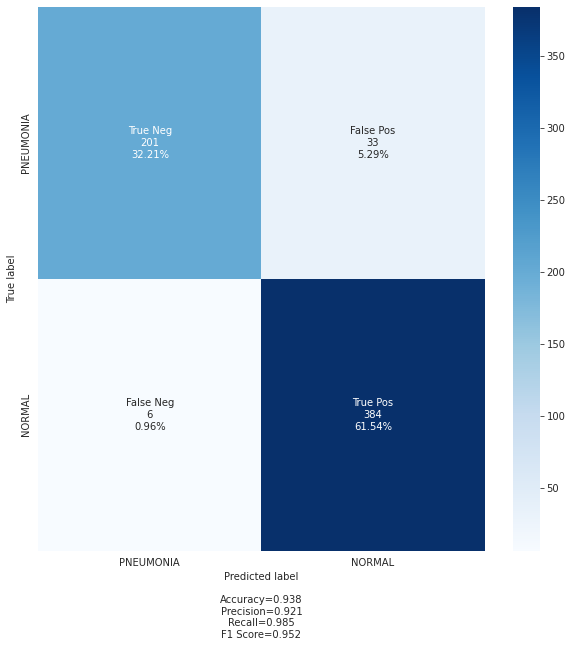

In [ ]:
heatmap_labels = ['True Neg','False Pos','False Neg','True Pos']
categories = labels

plt.figure(figsize = (10,10))
make_confusion_matrix(cm, 
                      group_names=heatmap_labels,
                      figsize = (10,10),
                      categories=categories, 
                      cmap='Blues')